<a href="https://colab.research.google.com/github/divza2106/Coursera_Capstone/blob/main/Battle_of_the_Neighborhoods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
pip install geocoder

     |████████████████████████████████| 102kB 3.9MB/s 


In [5]:
pip install pgeocode

In [6]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

##!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# import packages for web scrapping: beautifulsoup & requests
from bs4 import BeautifulSoup 
import requests
from urllib.request import urlopen

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

##!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

import geocoder # import geocoder
import pgeocode

print('Libraries imported!')

Libraries imported!


In [7]:
#Getting the data from url
url = "https://www.indiatvnews.com/pincode/telangana/hyderabad"
res = requests.get(url)
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0]
df = pd.read_html(str(table))
data = pd.read_json(df[0].to_json(orient='records'))
data.head()

,Office,Taluk,District,State,Pincode
0,A.Gs Office,Khairatabad,Hyderabad,TELANGANA,500004
1,A.Gs. Staff Quarters,Khairatabad,Hyderabad,TELANGANA,500045
2,Anandnagar Hyderabad,Khairatabad,Hyderabad,TELANGANA,500004
3,AP Police Academy PO,Rajendra Nagar,Hyderabad,TELANGANA,500091
4,Banjara Hills,Khairatabad,Hyderabad,TELANGANA,500034


In [8]:
#Dropping all rows where Taluk is 'NA'
df = data.dropna()

In [9]:
#Renaming the columns so that the Taluk is the Neighborhood and the Pincode is the Postal Code
df=df.rename(columns={"Office": "Neighborhood", "Taluk": "Borough", "Pincode": "Postal Code"})

In [10]:
#Removing duplicate entries of the neighborhoods.
df=df.drop_duplicates()

In [11]:
#reset the indices of the dataframe
df=df.reset_index()

In [12]:
address = 'Hyderabad, India'

geolocator = Nominatim(user_agent="hyd_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Hyderabad are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Hyderabad are 17.38878595, 78.46106473453146.


In [13]:
#figuring out the Longitude and Latitude of all places in the dataframe using the Postal Code
lat=[]
lon=[]
nomi = pgeocode.Nominatim('in')
for x in df['Postal Code']:
  lat.append(nomi.query_postal_code(x)[9])
  lon.append(nomi.query_postal_code(x)[10])

In [14]:
#adding the Latitude and Longitude values of each place to the dataframe
df["Latitude"]=lat
df["Longitude"]=lon
df.head()

,index,Neighborhood,Borough,District,State,Postal Code,Latitude,Longitude
0,0,A.Gs Office,Khairatabad,Hyderabad,TELANGANA,500004,17.3872,78.4621
1,1,A.Gs. Staff Quarters,Khairatabad,Hyderabad,TELANGANA,500045,17.5290,78.6839
2,2,Anandnagar Hyderabad,Khairatabad,Hyderabad,TELANGANA,500004,17.3872,78.4621
3,3,AP Police Academy PO,Rajendra Nagar,Hyderabad,TELANGANA,500091,17.3535,78.2402
4,4,Banjara Hills,Khairatabad,Hyderabad,TELANGANA,500034,17.4168,78.4384


In [15]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df['Borough'].unique()),
        len(df['Neighborhood'].unique())
    )
)

The dataframe has 33 boroughs and 231 neighborhoods.


In [16]:
# create map of Hyderabad using latitude and longitude values
map_hyd = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hyd)  
map_hyd

In [17]:
CLIENT_ID = 'YLKJ0AZHQUGH3BRKBOVY11KHXKQHF3K5K3SVRB0XMS3PUTQW' # your Foursquare ID
CLIENT_SECRET = '23QNBFLRVNUBHUTMTGACASQCU3RDI5CM33OBHRGICJGKLYXX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YLKJ0AZHQUGH3BRKBOVY11KHXKQHF3K5K3SVRB0XMS3PUTQW
CLIENT_SECRET:23QNBFLRVNUBHUTMTGACASQCU3RDI5CM33OBHRGICJGKLYXX


In [18]:
#function to get the venue name, id, lattitude, longitude, and category given the name, lattitude, and longitude of the neighborhood
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            50)        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['id'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']
            ) for v in results])


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue ID',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
hyd_venues=getNearbyVenues(df['Neighborhood'],df['Latitude'],df['Longitude'])

In [20]:
hyd_venues_temp1 = hyd_venues

In [21]:
len(hyd_venues_temp1)

569

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#function to get the number of likes and rating for each venue
likes = []
rating = []
for Venue_id in hyd_venues["Venue ID"]:
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
                Venue_id,
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
              )
    results = requests.get(url).json()    
    likes.append(results['response']['venue']['likes']["count"])    
    try:
      curr_rating = results['response']['venue']['rating']
    except:
      curr_rating = None
    rating.append(curr_rating)


In [ ]:
#adding the rating and likes to the dataframe
hyd_venues_temp1["Rating"] = rating

In [ ]:
hyd_venues_temp1["Likes"] = likes

In [261]:
len(hyd_venues_temp1)

569

In [125]:
#saving the dataframe as a csv so more Foursquare API calls do not need to be made
hyd_venues_temp1.to_csv("Hyderbad_Dataset.csv")

In [142]:

Hyderabad_df = pd.read_csv("/content/Hyderbad_Dataset.csv")

In [143]:
#dropping duplicate venues
Hyderabad_df = Hyderabad_df.drop_duplicates(subset=["Venue"])

In [263]:
len(Hyderabad_df)

140

In [145]:
#Not every rating for every venue was filled in so if there was no rating, we replaced the nan with the min of all the ratings in the dataframe
Hyderabad_df = Hyderabad_df.fillna(Hyderabad_df["Rating"].min())

In [146]:
Hyderabad_df["Rating"].min()

5.2

In [147]:
#Standardizing the Ratings on a scale from 0 to 1 by dividing each rating by its max possible value, 10
Hyderabad_df["Rating"] = Hyderabad_df["Rating"]/10

In [148]:
Hyderabad_df["Rating"].max()

0.89

In [149]:
##Standardizing the Likes on a scale from 0 to 1 by dividing each rating by its max possible value
Hyderabad_df["Likes"] = Hyderabad_df["Likes"]/Hyderabad_df["Likes"].max()

In [150]:
Hyderabad_df["Likes"].max()

1.0

In [151]:
Hyderabad_df["Overall_Score"] = 0.8*Hyderabad_df["Rating"] + 0.2* Hyderabad_df["Likes"]

In [152]:
hyd_venues_temp1.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,A.Gs Office,17.3872,78.4621,Al-humdulillah Hotel,4c6c20ef23c1a1cd47b218cf,17.390728,78.462992,Indian Restaurant
1,A.Gs Office,17.3872,78.4621,Carwan Garage,4f82a2b1e4b06d09fb314bb9,17.388943,78.464249,Auto Workshop
2,Anandnagar Hyderabad,17.3872,78.4621,Al-humdulillah Hotel,4c6c20ef23c1a1cd47b218cf,17.390728,78.462992,Indian Restaurant
3,Anandnagar Hyderabad,17.3872,78.4621,Carwan Garage,4f82a2b1e4b06d09fb314bb9,17.388943,78.464249,Auto Workshop
4,Banjara Hills,17.4168,78.4384,water,54f74881498eab131ee6f9ac,17.417200,78.442952,Hookah Bar


In [153]:
Hyderabad_df["Overall_Score"].min()

0.41600000000000004

In [154]:
Hyderabad_df["Overall_Score"].max()

0.9120000000000001

In [155]:
Hyderabad_df.head()

,Unnamed: 0,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category,Rating,Likes,Overall_Score
0,0,A.Gs Office,17.3872,78.4621,Al-humdulillah Hotel,4c6c20ef23c1a1cd47b218cf,17.390728,78.462992,Indian Restaurant,0.64,0.092199,0.530440
1,1,A.Gs Office,17.3872,78.4621,Feel in Saudi,4d60efc91ee8721e55b9b021,17.390702,78.463603,Afghan Restaurant,0.52,0.021277,0.420255
4,4,Banjara Hills,17.4168,78.4384,water,54f74881498eab131ee6f9ac,17.417200,78.442952,Hookah Bar,0.80,0.106383,0.661277
5,5,Banjara Hills,17.4168,78.4384,Subway,4b719ad8f964a52094502de3,17.414850,78.438248,Sandwich Place,0.69,0.007092,0.553418
6,6,Banjara Hills,17.4168,78.4384,Cafe Cubano,4d05ca607d9ba35d32fb6c23,17.416990,78.442824,Café,0.72,0.049645,0.585929


In [205]:
#Preparing the data for the XGBoost Model
X = Hyderabad_df.iloc[:,6:8]

In [206]:
Y = Hyderabad_df.iloc[:,-1]

In [207]:
X.head()

,Venue Latitude,Venue Longitude
0,17.390728,78.462992
1,17.390702,78.463603
4,17.417200,78.442952
5,17.414850,78.438248
6,17.416990,78.442824


In [208]:
len(Y)

140

In [209]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

In [210]:
data_dmatrix = xgb.DMatrix(data=X.values,label=Y.values)

In [211]:
#Splitting the training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=123)

In [165]:
#predictions
preds = xg_reg.predict(X_test.values)

In [166]:
#root mean squared error
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.067637


In [167]:
for index,x in Hyderabad_df.iterrows():
  if x[-1]==max:
    a=x

In [168]:
max=Hyderabad_df['Overall_Score'].max()

In [212]:
data_dmatrix = xgb.DMatrix(data=X.values,label=Y.values)

In [213]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[02:30:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:30:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:30:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [214]:
#the last rmse
print((cv_results["test-rmse-mean"]).tail(1))

0    0.104927
Name: test-rmse-mean, dtype: float64


In [215]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=100)

[02:30:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


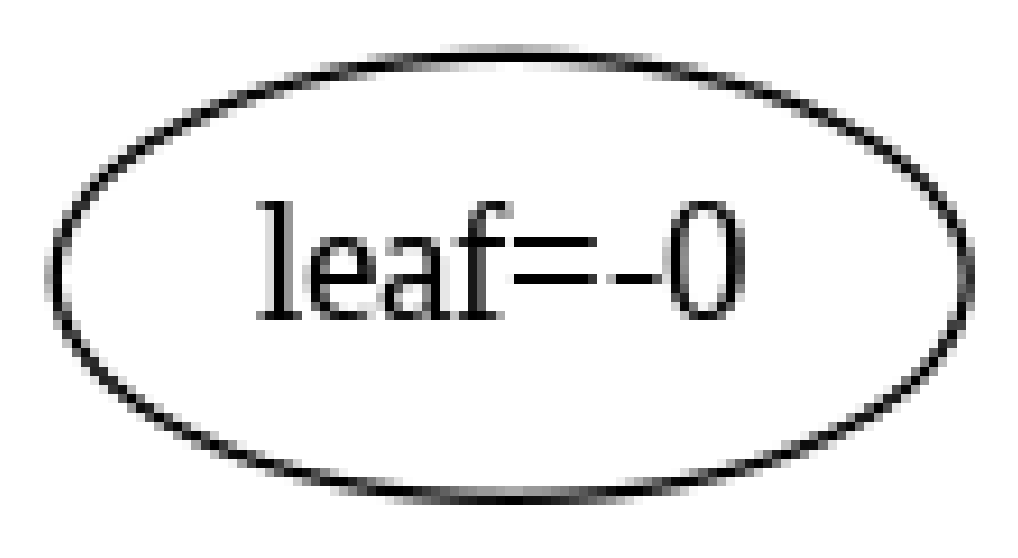

In [221]:
#the decision tree of the xgboost model
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg, num_trees=20)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

In [225]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [226]:
#fitting the model
xg_reg.fit(X_train.values,y_train.values)

[02:33:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

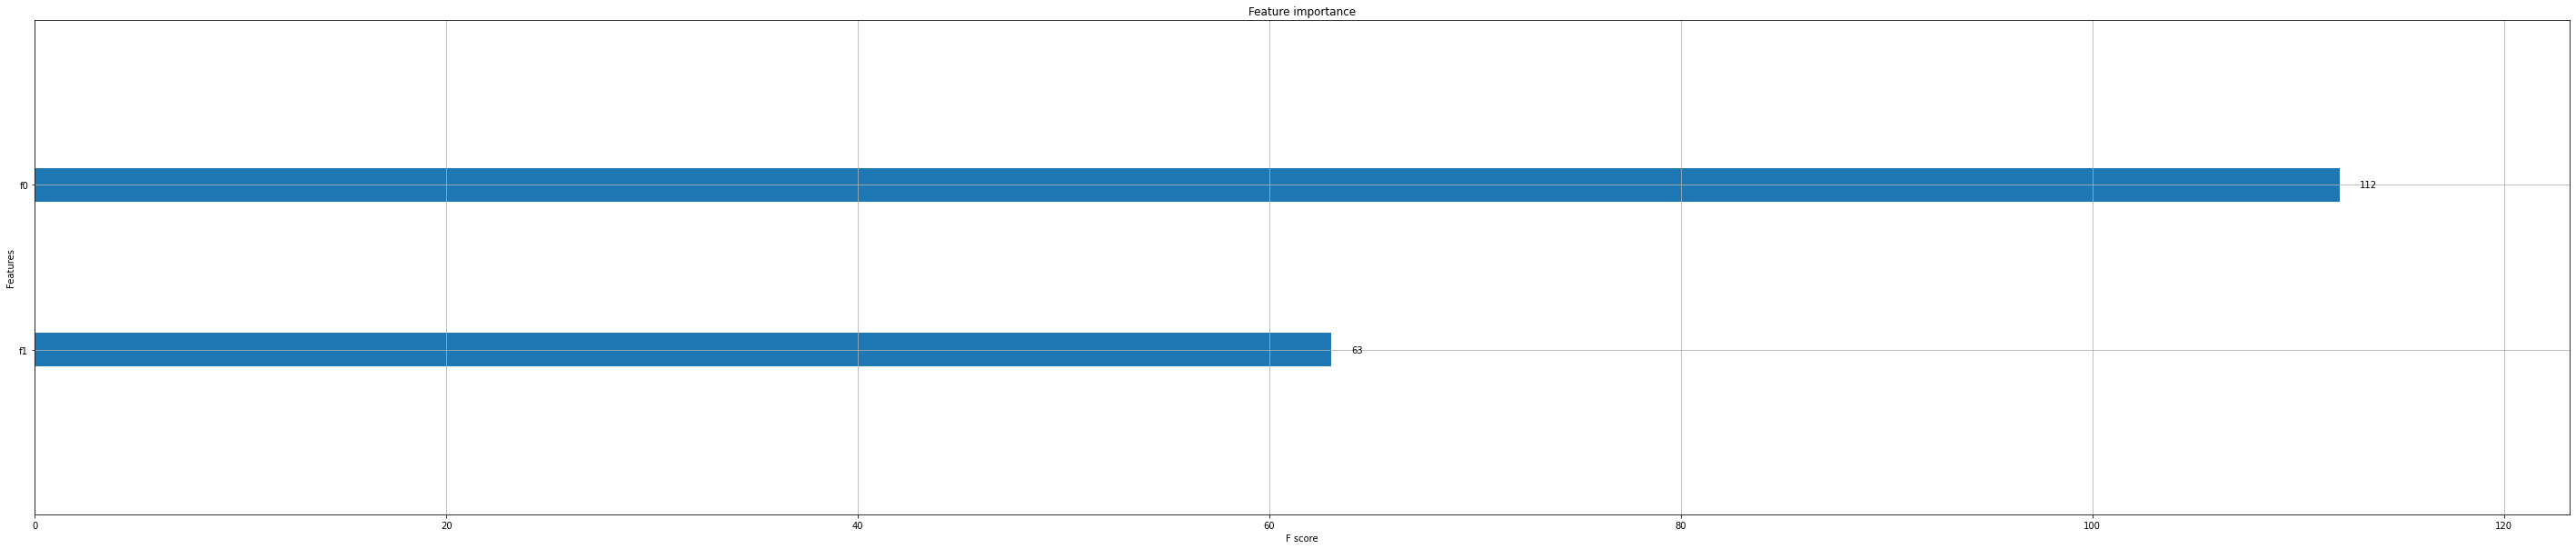

In [227]:
#finding which feature impacted the aggregated rating the most
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [ ]:
xg_reg.predict(data_dmatrix)

In [181]:
#importing zomato data about restaurants across the world
zomato = pd.read_csv("/content/zomato.csv",encoding = "ISO-8859-1")

In [182]:
zomato.head()

,Restaurant ID,Restaurant Name,Country Code,City,Address,Locality,Locality Verbose,Longitude,Latitude,Cuisines,Average Cost for two,Currency,Has Table booking,Has Online delivery,Is delivering now,Switch to order menu,Price range,Aggregate rating,Rating color,Rating text,Votes
0,6317637,Le Petit Souffle,162,Makati City,"Third Floor, Century City Mall, Kalayaan Avenu...","Century City Mall, Poblacion, Makati City","Century City Mall, Poblacion, Makati City, Mak...",121.027535,14.565443,"French, Japanese, Desserts",1100,Botswana Pula(P),Yes,No,No,No,3,4.8,Dark Green,Excellent,314
1,6304287,Izakaya Kikufuji,162,Makati City,"Little Tokyo, 2277 Chino Roces Avenue, Legaspi...","Little Tokyo, Legaspi Village, Makati City","Little Tokyo, Legaspi Village, Makati City, Ma...",121.014101,14.553708,Japanese,1200,Botswana Pula(P),Yes,No,No,No,3,4.5,Dark Green,Excellent,591
2,6300002,Heat - Edsa Shangri-La,162,Mandaluyong City,"Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...","Edsa Shangri-La, Ortigas, Mandaluyong City","Edsa Shangri-La, Ortigas, Mandaluyong City, Ma...",121.056831,14.581404,"Seafood, Asian, Filipino, Indian",4000,Botswana Pula(P),Yes,No,No,No,4,4.4,Green,Very Good,270
3,6318506,Ooma,162,Mandaluyong City,"Third Floor, Mega Fashion Hall, SM Megamall, O...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.056475,14.585318,"Japanese, Sushi",1500,Botswana Pula(P),No,No,No,No,4,4.9,Dark Green,Excellent,365
4,6314302,Sambo Kojin,162,Mandaluyong City,"Third Floor, Mega Atrium, SM Megamall, Ortigas...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.057508,14.584450,"Japanese, Korean",1500,Botswana Pula(P),Yes,No,No,No,4,4.8,Dark Green,Excellent,229


In [183]:
#deleting rows where the restaurant has not been rated
zomato=zomato[zomato["Rating text"]!='Not rated']

In [184]:
len(zomato)

7403

In [185]:
#for this model we only need the longitude, latitude, cusines, price range, and aggregate rating
zomato_new = zomato[["Longitude", "Latitude","Cuisines","Price range", "Aggregate rating"]]

In [186]:
#dropping all null values
zomato_new = zomato_new.dropna()

In [187]:
zomato_new.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)

In [188]:
#reseting index
zomato_new = zomato_new.reset_index(drop = True)

In [189]:
#for restaurants with more than one cuisine type, only using the first one
zomato_new["Cuisines"] = [zomato_new["Cuisines"][i].split(",")[0] for i in range(len(zomato_new))]

In [190]:
#turning each cusine string into a number
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
zomato_new['Cuisines']=le.fit_transform(zomato_new['Cuisines'])

In [229]:
#the X is the longitude, latitude, cuisines, and price range 
X = zomato_new.iloc[:, 0:-1]

In [230]:
X.head()

,Longitude,Latitude,Cuisines,Price_range
0,121.027535,14.565443,38,3
1,121.014101,14.553708,54,3
2,121.056831,14.581404,96,4
3,121.056475,14.585318,54,4
4,121.057508,14.584450,54,4


In [231]:
# y is the aggregated rating
y = zomato_new.iloc[:, -1]

In [232]:
len(X)

7394

In [233]:
y.max()

4.9

In [234]:
for index,x in zomato.iterrows():
  if x[10]==max:
    a=x

In [235]:
#splitting into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

In [236]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [237]:
#fitting the model
xg_reg.fit(X_train.values,y_train.values)

[02:35:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [238]:
zomato_new.head()

,Longitude,Latitude,Cuisines,Price_range,Aggregate_rating
0,121.027535,14.565443,38,3,4.8
1,121.014101,14.553708,54,3,4.5
2,121.056831,14.581404,96,4,4.4
3,121.056475,14.585318,54,4,4.9
4,121.057508,14.584450,54,4,4.8


In [239]:
#prediction
preds = xg_reg.predict(X_test.values)

In [240]:
#root mean square error
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 1.118870


In [241]:
data_dmatrix = xgb.DMatrix(data=X.values,label=y.values)

In [242]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[02:35:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:35:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:35:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [243]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,2.701345,0.005301,2.701332,0.012722
1,2.441192,0.005219,2.441542,0.013109
2,2.208612,0.004535,2.209115,0.014021
3,1.999344,0.004383,1.999636,0.014377
4,1.813071,0.003940,1.813622,0.014858


In [244]:
#the rmse was reduced to 0.423527
print((cv_results["test-rmse-mean"]).tail(1))

49    0.423527
Name: test-rmse-mean, dtype: float64


In [245]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=100)

[02:35:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


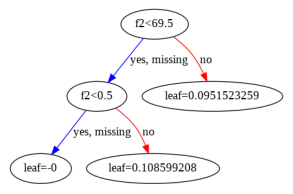

In [246]:
#the decision tree of the xgboost model
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg, num_trees=10)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

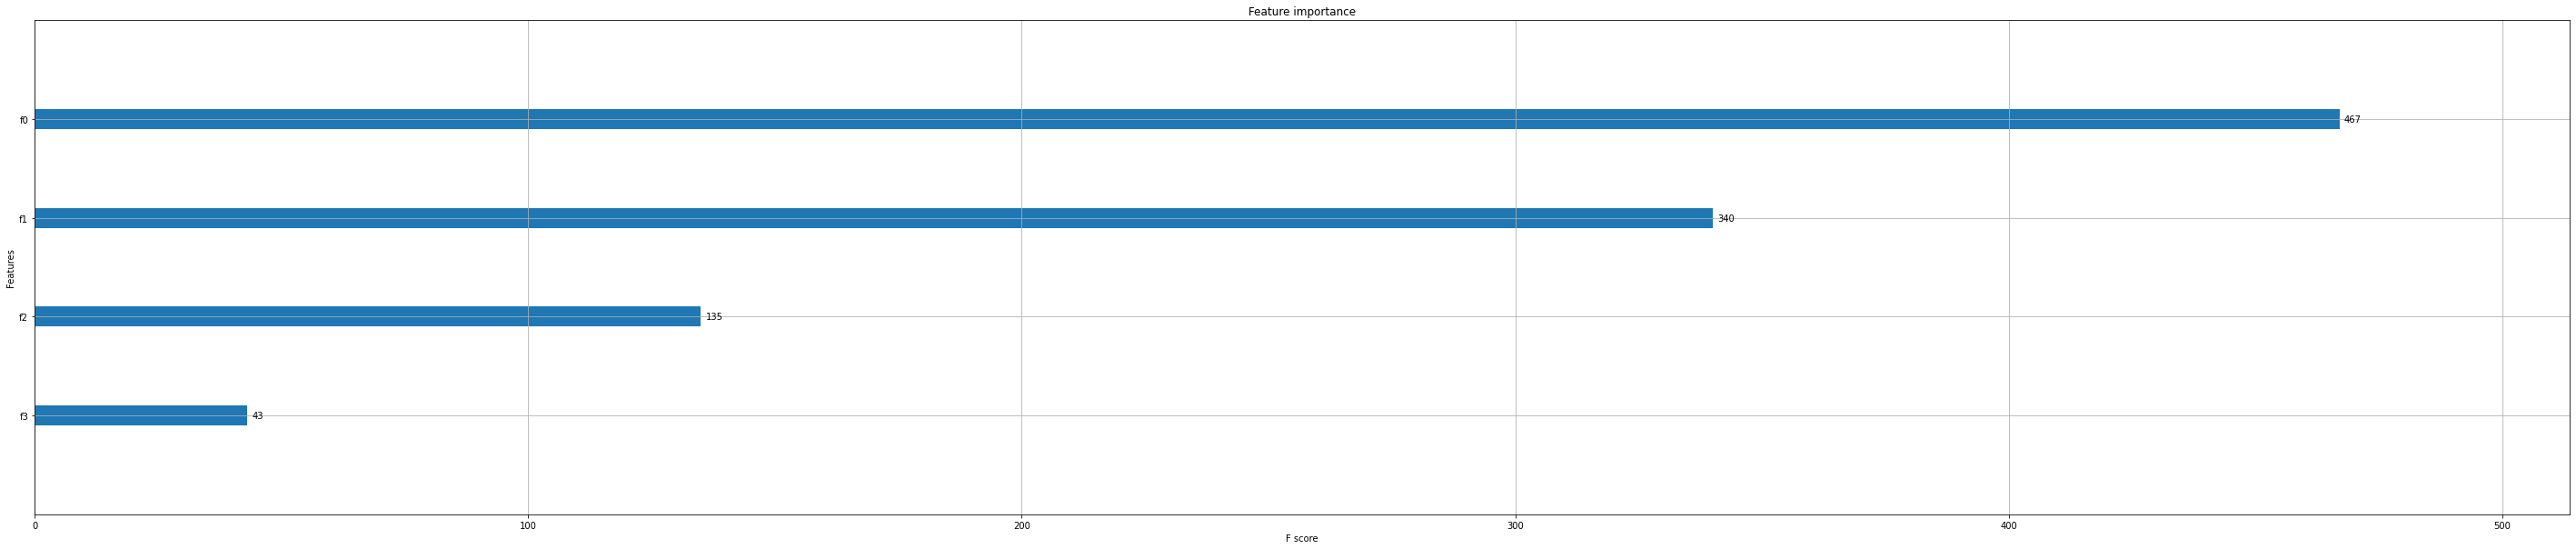

In [247]:
#finding which feature impacted the aggregated rating the most
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [250]:
#predicting the aggregate rating of the lowest rated venue
min = zomato_new["Aggregate_rating"].min()

In [252]:
for index,y in zomato_new.iterrows():
  if y[-1]==min:
    a=y

In [255]:
a

Longitude           77.370165
Latitude            28.633970
Cuisines            78.000000
Price_range          3.000000
Aggregate_rating     1.800000
Name: 1019, dtype: float64

In [ ]:
#in the future, if you want to predict the rating of any restaurant:
#set a=[longitude,latitude,cusine,price range]
a = [ -73.998543, 40.715365, 44.000000, 2]

In [256]:
data_dmatrix = xgb.DMatrix(data=a[0:-1])

In [257]:
xg_reg.predict(data_dmatrix)

array([3.2084422], dtype=float32)

In [260]:
#list of all the cusines and the number they respond to 
for i in range(zomato_new["Cuisines"].nunique()):
  print(str(i) + " " + le.inverse_transform([i]))

['0 Afghani']
['1 African']
['2 American']
['3 Andhra']
['4 Arabian']
['5 Argentine']
['6 Asian']
['7 Asian Fusion']
['8 Assamese']
['9 Australian']
['10 Awadhi']
['11 BBQ']
['12 Bakery']
['13 Bar Food']
['14 Bengali']
['15 Beverages']
['16 Bihari']
['17 Biryani']
['18 Brazilian']
['19 Breakfast']
['20 British']
['21 Burger']
['22 Burmese']
['23 Cafe']
['24 Cajun']
['25 Caribbean']
['26 Charcoal Grill']
['27 Chinese']
['28 Coffee and Tea']
['29 Contemporary']
['30 Continental']
['31 Cuban']
['32 Desserts']
['33 Drinks Only']
['34 European']
['35 Fast Food']
['36 Filipino']
['37 Finger Food']
['38 French']
['39 German']
['40 Goan']
['41 Gourmet Fast Food']
['42 Greek']
['43 Grill']
['44 Gujarati']
['45 Hawaiian']
['46 Healthy Food']
['47 Hyderabadi']
['48 Ice Cream']
['49 Indian']
['50 Indonesian']
['51 International']
['52 Irish']
['53 Italian']
['54 Japanese']
['55 Juices']
['56 Kashmiri']
['57 Kebab']
['58 Kerala']
['59 Kiwi']
['60 Korean']
['61 Latin American']
['62 Lebanese']
['63 